In [1]:
%load_ext autoreload
%autoreload 2

# Test parameter recovery performance for different tasks and task properties

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import rl

%matplotlib inline


matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

# Types of tasks considered

## Reversal Learning Task (`rv`-Task)

As a reference, this type of task is used in Kahnt, Park et al. (2008, Journal of Cognitive Neuroscience; "KP08").  
In this task, only one state is visible to the agent (every trial looks identical to the agent).  
A latent (unobservable) true state governs the reward probabilities of different actions. The latent state switches periodically, dividing the task into episodes.

The properties of this task that can be adjusted are:

1. The set of latent states that the task switches between. Each latent state in the state set contains the probabilities of different rewards associated the different actions.
3. The transition properties between the latent states (i.e., the conditions and / or probabilities under which the latent state changes). This includes, for example, the minimum and maximum number of trials in each episode (without state switches).
3. The number of trials and blocks.

## Multiple State Task (`ms`-Task)

This type of task was, for example, used in Lefebvre et al. (2017, Nature Human Behaviour; "L17").  
Here, the states controlling the reward probabilities of different actions are observable by the agent (e.g., each state is associated with a different set of symbols that are presented in a trial).

The properties of this task that can be adjusted are:
1. The set of (observable) states, containing the probabilities of different rewards associated with different actions in each trial.
2. The sequence and frequence of different states occuring.
2. The number of trials and blocks.

# Set of tasks to be compared

In this analysis, I will consider the following task instances, for each varying the number of trials, and performing a parameter recovery analysis, to address the question, which task is best suited for recovering the learning rate parameters of a basic dual-learning-rate delta-rule agent:

Each of the following tasks will have two possible actions (say, left and right).

## `rv`-Task variants

I test 6 variants of the `rv`-Task, obtained by combining three sets of states with two settings of transition 

- State sets
    - A: 80:20, 20:80, 50:50 (as in KP08)
        - `{"Right correct": {p_r=[0.2, 0.8], rewards=[0.5, 0]}}`
        - `{"Left correct": {p_r=[0.8, 0.2], rewards=[0.5, 0]}}`
        - `{"Both correct": {p_r=[0.5, 0.5], rewards=[0.5, 0]}}`
    - B: 80:20, 20:80 (no 50:50)
        - `{"Right correct": {p_r=[0.2, 0.8], rewards=[0.5, 0]}}`
        - `{"Left correct": {p_r=[0.8, 0.2], rewards=[0.5, 0]}}`


- Transition settings
    - X: `min=10, max=16, acc=0.7` (as in KP08)
    - Y: `min=5, max=20, acc=0.7`


## `ms`-Task variants

I test 3 variants of the `ms`-Task, obtained by combining three sets of states with two settings of transition 

- State sets
    - C: Gains vs. Nothing (as in L17, Exp. 1)
        - `{"both bad": {p_r=[0.25, 0.25], rewards=[0.5, 0]}}`
        - `{"left good": {p_r=[0.75, 0.25], rewards=[0.5, 0]}}`
        - `{"right good": {p_r=[0.25, 0.75], rewards=[0.5, 0]}}`
        - `{"both good": {p_r=[0.75, 0.75], rewards=[0.5, 0]}}`
    - D: Gains vs. Losses (as in L17, Exp. 2)
        - `{"both bad": {p_r=[0.25, 0.25], rewards=[0.5, -0.5]}}`
        - `{"left good": {p_r=[0.75, 0.25], rewards=[0.5, -0.5]}}`
        - `{"right good": {p_r=[0.25, 0.75], rewards=[0.5, -0.5]}}`
        - `{"both good": {p_r=[0.75, 0.75], rewards=[0.5, -0.5]}}`

- Sequence, frequence
    - Z: random sequence of states, equal frequence

# Example: Structure of a single recovery

In [3]:
# %% 1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)
# ------------------------------------------------------------------------
print("1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)")
print("---------------------------------------------------------------------")

# Set up the three different states (we changed the rewards from 1 to 0.5, for parameter values to better work with both tasks)
rv_states = {
    # 20:80
    0: {"p_r": [0.2, 0.8], "a_correct": [1], "rewards": [0.5, 0]},
    # 80:20
    1: {"p_r": [0.8, 0.2], "a_correct": [0], "rewards": [0.5, 0]},
    # 50:50
    2: {"p_r": [0.5, 0.5], "a_correct": [0, 1], "rewards": [0.5, 0]},
}
rv_task_vars = rl.task.TaskVars(
    n_trials=100,
    n_blocks=5,
    n_options=2,
    states=rv_states,
    n_trials_reversal_min=10,  # minimum number of trials before reversal
    n_trials_reversal_max=16,  # maximum number of trials without reversal
    p_correct_reversal_min=0.7,  # minimum accuracy before reversal before `n_trials_reversal_max`
)

rv_task = rl.task.ReversalLearningTask(task_vars=rv_task_vars)
print(rv_task)

1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)
---------------------------------------------------------------------
Reversal learning task with the states (rules):
  {0: {'p_r': [0.2, 0.8], 'a_correct': [1], 'rewards': [0.5, 0]}, 1: {'p_r': [0.8, 0.2], 'a_correct': [0], 'rewards': [0.5, 0]}, 2: {'p_r': [0.5, 0.5], 'a_correct': [0, 1], 'rewards': [0.5, 0]}}


In [4]:
# %% 2. Set up Dual-Learning-Rate Agent
# -------------------------------------
print("2. Set up Dual-Learning-Rate Agent")
print("----------------------------------")


# Use mean parameters from Lefebvre et al. (2017)
agent_vars = rl.agent.AgentVars(
    alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13), variant="delta"
)
agent = rl.agent.DualLearningRateAgent(
    agent_vars=agent_vars, n_options=rv_task.task_vars.n_options
)
print(agent)

2. Set up Dual-Learning-Rate Agent
----------------------------------
Dual learning rate agent (delta variant) with
  alpha_pos = 0.36
  alpha_neg = 0.22
  beta = 7.69


In [5]:
# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0, 20)}

# Initialize estimation variables and estimation instance
# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    rv_task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=2,  # number of estimatino starting points
)
est = rl.estimation.Estimation(est_vars)

## Run recovery

In [6]:
N = 5 # number of individuals / set of parameters to recover

parameter_values = dict(
    alpha_pos=np.random.uniform(*bounds["alpha_pos"], N),
    alpha_neg=np.random.uniform(*bounds["alpha_neg"], N),
    beta=np.random.uniform(*bounds["beta"], N),
)

result = rl.recovery.run_estimate_recovery(
    task=rv_task, agent=agent, est=est, parameter_values=parameter_values
)

result.head()

,idx,n_trials,n_blocks,n_sp,nll,bic,alpha_pos,alpha_pos_hat,alpha_neg,alpha_neg_hat,beta,beta_hat
0,0,100,5,2,134.304532,287.252888,0.262521,0.506225,0.376368,0.352681,17.919031,11.340420
1,1,100,5,2,145.710069,310.063961,0.559268,1.000000,0.960317,0.994621,18.077800,11.571374
2,2,100,5,2,225.662205,469.968234,0.536211,1.000000,0.405514,0.343476,15.549128,7.489428
3,3,100,5,2,275.377558,569.398941,0.138769,0.261811,0.919305,0.823395,10.688370,6.627809
4,4,100,5,2,346.573590,711.791005,0.776116,0.000000,0.431652,0.000000,4.889563,0.000000


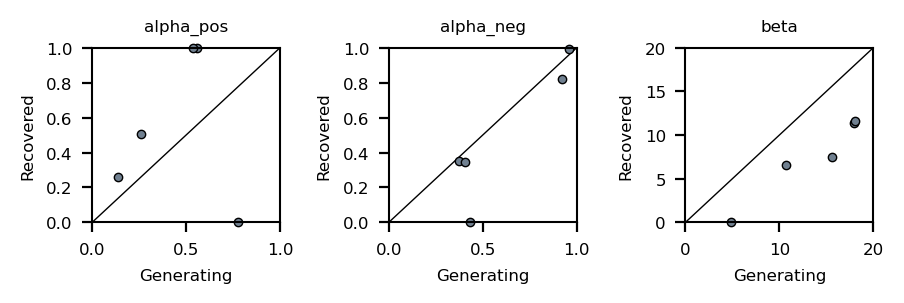

In [7]:
# Plot recovery results
fig, axs = plt.subplots(1, 3, figsize=(4.5, 1.5), dpi=200)
for p, parameter in enumerate(["alpha_pos", "alpha_neg", "beta"]):
    axs[p].set_title(parameter)
    axs[p].plot(
        result[parameter],
        result[f"{parameter}_hat"],
        "o",
        markeredgewidth=0.5,
        markersize=3,
        clip_on=False,
    )
    axs[p].plot(
        bounds[parameter], bounds[parameter], zorder=-1, linewidth=0.5, color="black"
    )
    axs[p].set_xlabel("Generating")
    axs[p].set_ylabel("Recovered")
    axs[p].set_xlim(bounds[parameter])
    axs[p].set_ylim(bounds[parameter])

fig.tight_layout()

# Run recovery for all task variants

In [8]:
# General settings
np.random.seed(1)

n_trials = 50  # numbers of trials per block
n_sp = 5  # numbers of estimation starting points
N = 100  # numbers of subjects with random (uniform within bounds) parameter values
block_range = range(1, 7)  # range of number of blocks to be varied

parameter_values = dict(
    alpha_pos=np.random.uniform(*bounds["alpha_pos"], N),
    alpha_neg=np.random.uniform(*bounds["alpha_neg"], N),
    beta=np.random.uniform(*bounds["beta"], N),
)

## RV 

In [9]:
rv_state_sets = {
    "A": {
        0: {"p_r": [0.2, 0.8], "a_correct": [1], "rewards": [0.5, 0]},
        1: {"p_r": [0.8, 0.2], "a_correct": [0], "rewards": [0.5, 0]},
        2: {"p_r": [0.5, 0.5], "a_correct": [0, 1], "rewards": [0.5, 0]},
    },
    "B": {
        0: {"p_r": [0.2, 0.8], "a_correct": [1], "rewards": [0.5, 0]},
        1: {"p_r": [0.8, 0.2], "a_correct": [0], "rewards": [0.5, 0]},
    },
}

rv_transition_sets = {
    "X": {
        "n_trials_reversal_min": 10,
        "n_trials_reversal_max": 16,
        "p_correct_reversal_min": 0.7,
    },
    "Y": {
        "n_trials_reversal_min": 5,
        "n_trials_reversal_max": 20,
        "p_correct_reversal_min": 0.7,
    },
}

In [10]:
results_rv = []

pbar = tqdm(total=2 * len(rv_state_sets) * len(rv_transition_sets) * len(block_range))

for variant in ["r", "delta"]:
    for state_set_label, state_set in rv_state_sets.items():
        for transition_set_label, transition_set in rv_transition_sets.items():
            for n_blocks in block_range:

                # Set up task
                rv_task_vars = rl.task.TaskVars(
                    n_trials=n_trials,
                    n_blocks=n_blocks,
                    n_options=2,
                    states=state_set,
                    n_trials_reversal_min=transition_set[
                        "n_trials_reversal_min"
                    ],  # minimum number of trials before reversal
                    n_trials_reversal_max=transition_set[
                        "n_trials_reversal_max"
                    ],  # maximum number of trials without reversal
                    p_correct_reversal_min=transition_set[
                        "p_correct_reversal_min"
                    ],  # minimum accuracy before reversal before `n_trials_reversal_max`
                )
                rv_task = rl.task.ReversalLearningTask(task_vars=rv_task_vars)

                # Set up agent
                # Use mean parameters from Lefebvre et al. (2017)
                agent_vars = rl.agent.AgentVars(
                    alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13), variant=variant
                )
                agent = rl.agent.DualLearningRateAgent(
                    agent_vars=agent_vars, n_options=rv_task.task_vars.n_options
                )

                # Set up estimation
                # Define parameters to estimate
                parameters = ["alpha_pos", "alpha_neg", "beta"]

                # Set boundaries (used to initialize and constrain estimation)
                bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0, 20)}

                # Initialize estimation variables and estimation instance
                # Note, that we also need to specify the agent_class (i.e., the agent "model")
                est_vars = rl.estimation.EstimationVars(
                    rv_task_vars,
                    agent_class=rl.agent.DualLearningRateAgent,
                    parameters=parameters,
                    bounds=bounds,
                    n_sp=n_sp,
                )
                est = rl.estimation.Estimation(est_vars)

                # Run recovery
                result = rl.recovery.run_estimate_recovery(
                    task=rv_task,
                    agent=agent,
                    est=est,
                    parameter_values=parameter_values,
                    verbose=False,
                )
                result["state_set"] = state_set_label
                result["transition_set"] = transition_set_label
                result["task"] = "rv"
                result["variant"] = variant
                results_rv.append(result)
                pd.concat(results_rv).to_csv(
                    "test_task_recovery_rv.csv"
                )  # intermediate save
                pbar.update(1)

results_rv = pd.concat(results_rv)
results_rv.to_csv("test_task_recovery_rv.csv")

## `ms`

In [11]:
ms_state_sets = {
    "D": {
        0: {"p_r": [0.25, 0.25], "a_correct": [0, 1], "rewards": [0.5, 0]},
        1: {"p_r": [0.75, 0.25], "a_correct": [0], "rewards": [0.5, 0]},
        2: {"p_r": [0.25, 0.75], "a_correct": [1], "rewards": [0.5, 0]},
        3: {"p_r": [0.75, 0.75], "a_correct": [0, 1], "rewards": [0.5, 0]},
    },
    "E": {
        0: {"p_r": [0.25, 0.25], "a_correct": [0, 1], "rewards": [0.5, -0.5]},
        1: {"p_r": [0.75, 0.25], "a_correct": [0], "rewards": [0.5, -0.5]},
        2: {"p_r": [0.25, 0.75], "a_correct": [1], "rewards": [0.5, -0.5]},
        3: {"p_r": [0.75, 0.75], "a_correct": [0, 1], "rewards": [0.5, -0.5]},
    },
}

In [12]:
results_ms = []

pbar = tqdm(total=len(ms_state_sets) * len(block_range))

for variant in ["r", "delta"]:
    for state_set_label, state_set in ms_state_sets.items():
        for n_blocks in block_range:

            # Build sequence of trials / states (n_blocks x n_trials)
            n_states = len(state_set)
            state_sequence = np.repeat(
                np.repeat(np.arange(n_states), n_trials // n_states)[:, None],
                n_blocks,
                axis=1,
            )

            ## Shuffle within each block
            [
                np.random.shuffle(state_sequence[:, block])
                for block in range(state_sequence.shape[1])
            ]

            # Set up task
            ms_task_vars = rl.task.TaskVars(
                n_options=2, states=state_set, state_sequence=state_sequence.T
            )
            ms_task = rl.task.MultipleStateTask(task_vars=ms_task_vars)

            # Set up agent
            # Use mean parameters from Lefebvre et al. (2017)
            agent_vars = rl.agent.AgentVars(
                alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13), variant=variant,
            )
            agent = rl.agent.DualLearningRateAgent(
                agent_vars=agent_vars,
                n_options=ms_task.task_vars.n_options,
                n_states=n_states,
            )

            # Set up estimation
            # Define parameters to estimate
            parameters = ["alpha_pos", "alpha_neg", "beta"]

            # Set boundaries (used to initialize and constrain estimation)
            bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0, 20)}

            # Initialize estimation variables and estimation instance
            # Note, that we also need to specify the agent_class (i.e., the agent "model")
            est_vars = rl.estimation.EstimationVars(
                ms_task_vars,
                agent_class=rl.agent.DualLearningRateAgent,
                parameters=parameters,
                bounds=bounds,
                n_sp=n_sp,
            )
            est = rl.estimation.Estimation(est_vars)

            # Run recovery
            result = rl.recovery.run_estimate_recovery(
                task=ms_task,
                agent=agent,
                est=est,
                parameter_values=parameter_values,
                verbose=False,
            )
            result["state_set"] = state_set_label
            result["transition_set"] = "Z"
            result["task"] = "ms"
            result["variant"] = variant
            results_ms.append(result)
            pd.concat(results_ms).to_csv(
                "test_task_recovery_ms.csv"
            )  # intermediate save
            pbar.update(1)

results_ms = pd.concat(results_ms)
results_ms.to_csv("test_task_recovery_ms.csv")

## Combine results

In [13]:
results = pd.concat([results_rv, results_ms]).reset_index(drop=True)
results.to_csv("test_task_recovery.csv")

# Analyse results

- Which task has the lower recovery error given the same number of trials?
- Which task properties are associated with a lower recovery error?
- How many trials are needed for "good" recovery?

## Quantifying recovery performance

I'll quantify error performance as the mean squared error between generating and recovered estimates, summed across the three parameters. Because the parameters have different scales (alphas go from 0 to 1, beta goes from 0 to 20), I will weight errors for the beta parameter by $\frac{1}{20}$

$$e = \sum_i{(\hat{\alpha}^+_i - \alpha^+_i)^2 + (\hat{\alpha}^-_i - \alpha^-_i)^2 + \frac{1}{20}(\hat{\beta}_i - \beta_i)^2}$$

In [14]:
# compute error for each individual i
for parameter in ["alpha_pos", "alpha_neg", "beta"]:
    results[f"error_{parameter}"] = (
        results[f"{parameter}_hat"] - results[parameter]
    ) ** 2

In [15]:
results["total_weighted_error"] = (
    results["error_alpha_pos"]
    + results["error_alpha_neg"]
    + (1 / 20) * results["error_beta"]
)

# Visualize results

In [16]:
import seaborn as sns

In [17]:
results.groupby(["task", "state_set", "transition_set", "n_blocks"])[
    ["error_alpha_pos", "error_alpha_neg", "error_beta", "total_weighted_error"]
].mean()

error_alpha_pos  error_alpha_neg  \
task state_set transition_set n_blocks                                     
ms   D         Z              1                0.154498         0.072373   
                              2                0.148562         0.072863   
                              3                0.109650         0.039114   
                              4                0.108988         0.062076   
                              5                0.134030         0.038151   
                              6                0.100607         0.045054   
     E         Z              1                0.192168         0.063724   
                              2                0.189315         0.064475   
                              3                0.166084         0.044170   
                              4                0.154694         0.045924   
                              5                0.140513         0.040452   
                              6                0.140625         0.040347   
rv   A         X              1                0.172888         0.078857   
                              2                0.154595         0.066619   
                              3                0.113749         0.068238   
                              4                0.100439         0.057869   
                              5                0.097353         0.047582   
                              6                0.095357         0.030949   
               Y              1                0.159856         0.088811   
                              2                0.105538         0.054964   
                              3                0.112874         0.049297   
                              4                0.085033         0.044568   
                              5                0.114683         0.045084   
                              6                0.086441         0.055877   
     B         X              1                0.151615         0.109103   
                              2                0.122369         0.059004   
                              3                0.072886         0.057582   
                              4                0.088378         0.055618   
                              5                0.071327         0.053288   
                              6                0.092097         0.029450   
               Y              1                0.129452         0.057704   
                              2                0.112124         0.067618   
                              3                0.105840         0.036866   
                              4                0.083586         0.045724   
                              5                0.096787         0.043784   
                              6                0.078746         0.048301   

                                        error_beta  total_weighted_error  
task state_set transition_set n_blocks                                    
ms   D         Z              1          34.803601              1.967052  
                              2          36.935124              2.068182  
                              3          30.312431              1.664386  
                              4          37.801720              2.061149  
                              5          40.371095              2.190736  
                              6          35.282104              1.909766  
     E         Z              1          55.476251              3.029705  
                              2          57.051646              3.106372  
                              3          62.440612              3.332285  
                              4          59.017446              3.151490  
                              5          60.207357              3.191332  
                              6          58.804702              3.121206  
rv   A         X              1          50.859359              2.794713  
                          

In [20]:
alpha_errors = pd.melt(
    results,
    id_vars=["task", "state_set", "transition_set", "n_blocks", "idx", "variant"],
    value_vars=["error_alpha_pos", "error_alpha_neg"],
    var_name="parameter",
    value_name="error",
)

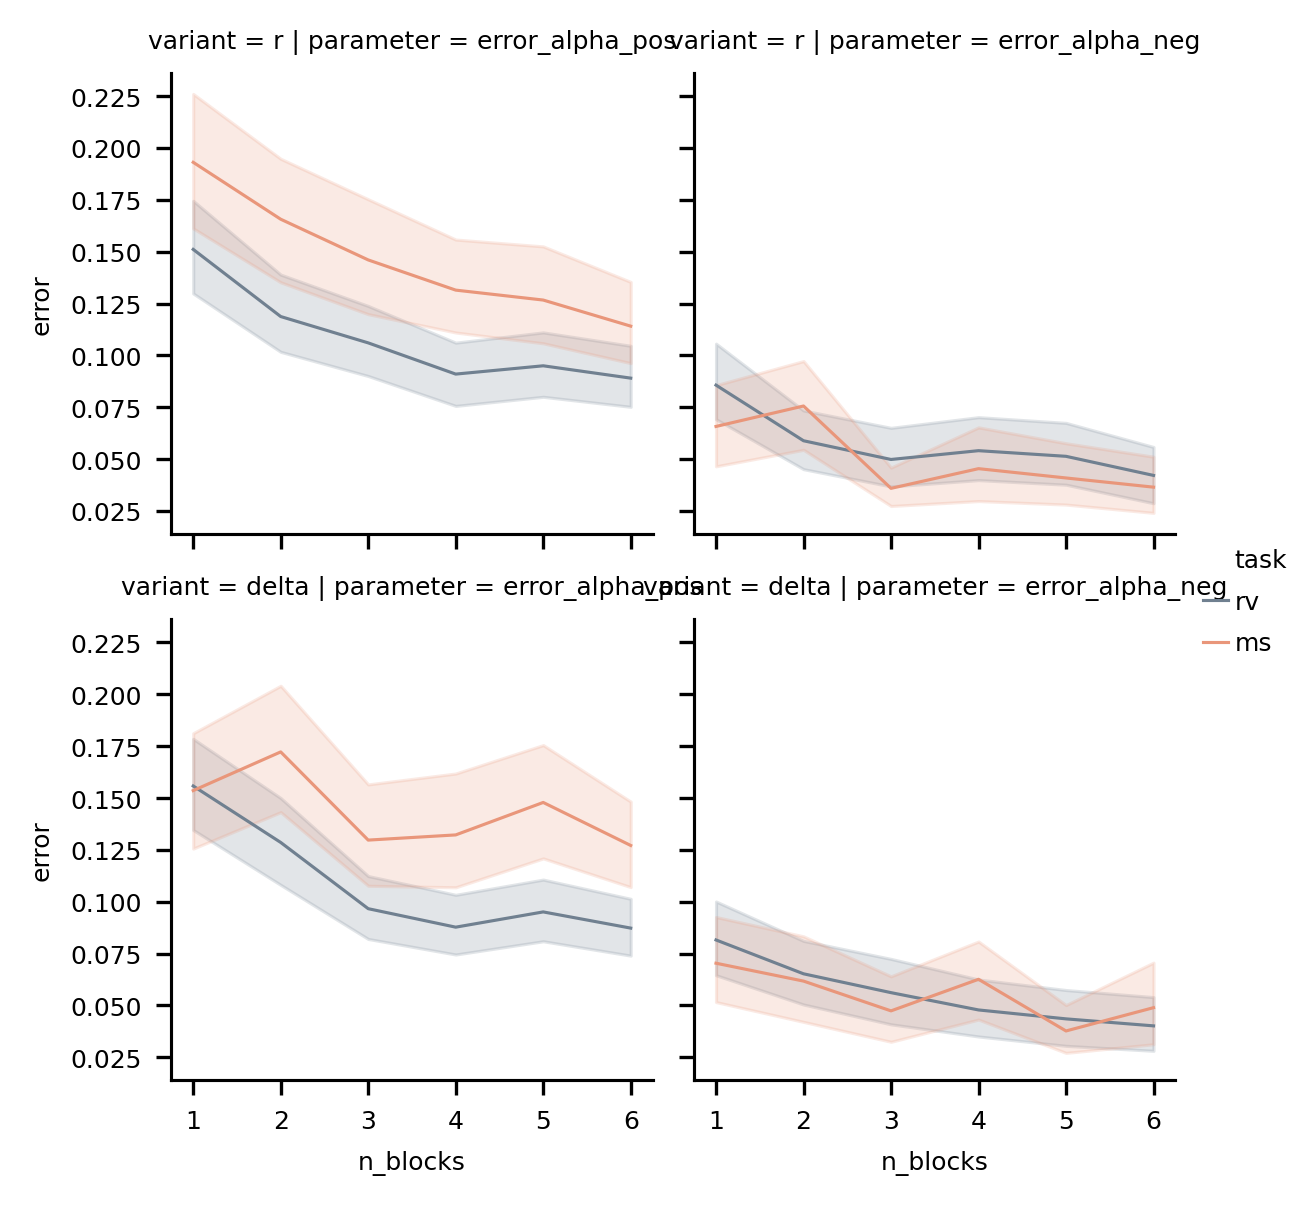

In [21]:
sns.relplot(
    x="n_blocks",
    y="error",
    col="parameter",
    row="variant",
    hue="task",
    data=alpha_errors,
    kind="line",
    height=2,
    aspect=1,
);

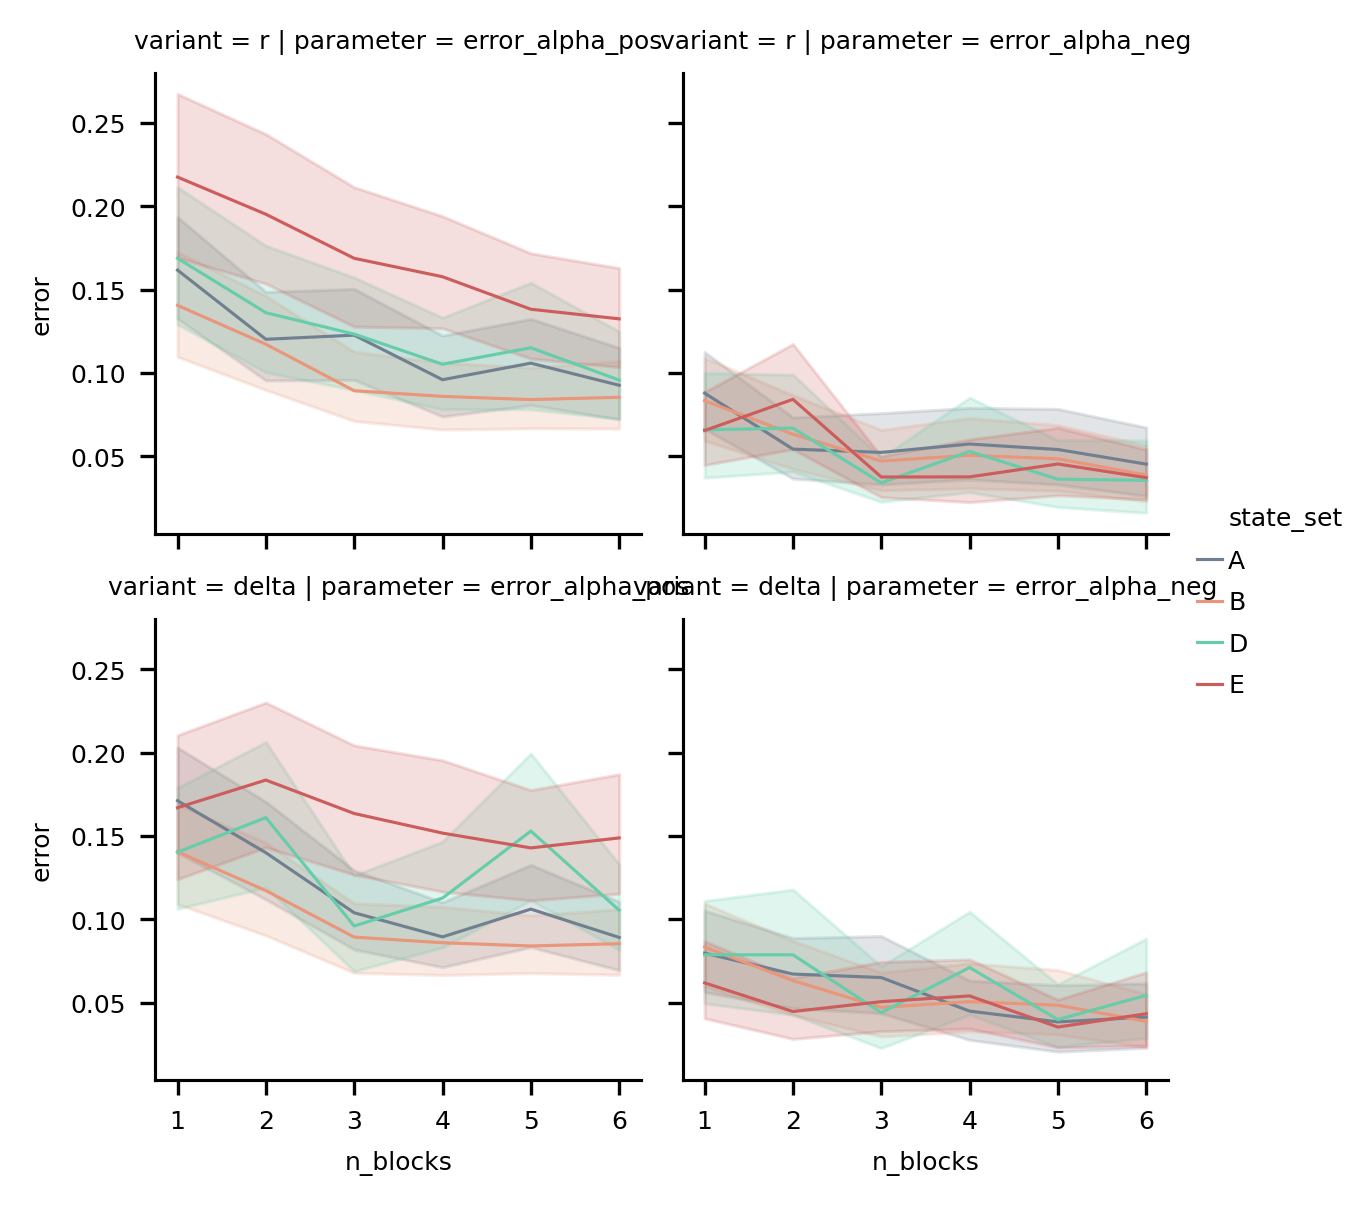

In [22]:
sns.relplot(
    x="n_blocks",
    y="error",
    col="parameter",
    row="variant",
    hue="state_set",
    data=alpha_errors,
    kind="line",
    height=2,
    aspect=1,
);